# PROGRAM FDinplane
2-d rectangle o-4 stress velocity inplane

Stefan Nielsen - June 2018

import standard python libraries:

In [1]:
# Stefan Nielsen 2018 - various lib import:
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
import os
import time
import numpy as np
%matplotlib notebook
import matplotlib
#import matplotlib.pyplot as plt
#matplotlib.interactive(True)
from pylab import plot, xlabel, ylabel
from pylab import *
from scipy import arange
from IPython import display
from matplotlib import animation, rc
import matplotlib.ticker as ticker
#####

initialise parameters and arrays, importing from local files:

In [2]:
from FDfpar import *       #
from FDarrays import *     #

mu[:,:]=28.e9
lam[:,:]=28.e9
rho[:,:]=2700.
rn=9./8.;rnn=-1/24.;
#
# viscoelastic attenuation (relaxation time) at the boundaries:
diss[:,:]=.1;lbuf=3.0;dimi=.002;nbuf=15;
for i in range(nbuf): diss[:,i]=(diss[:,i]-dimi)*np.exp(-(float(nbuf-i)/lbuf)**2)+dimi
for i in range(nx-nbuf,nx): diss[:,i]=(diss[:,i]-dimi)*np.exp(-(float(i-nx+nbuf+1)/lbuf)**2)+dimi
for j in range(ny-nbuf,ny): diss[j,:]=(diss[j,:]-dimi)*np.exp(-(float(j-ny+nbuf+1)/lbuf)**2)+dimi
# source position:
nxs=30;nys=2;
# initialize variables:
def init(v1,v2,s11,s22,s12):
    v1[:,:]=0;v2[:,:]=0;s11[:,:]=0;s22[:,:]=0;s12[:,:]=0;

f, axarr = plt.subplots(1,1,figsize=(6,2))
axarr.plot(diss[:,30])
axarr.set_title('diss');
f.canvas.draw()

In [3]:
# here you can modify the model by adding ihomogenieities:
for j in range(15,ny):
    mu[j,:]=2*mu[j,:]    
    lam[j,:]=2*lam[j,:]

define functions:

In [4]:
def memvar(m11,mm11,m22,mm22,m12,mm12):
    # memory variables for viscoelastic attenuation
    mm11=m11[:,:]
    mm22=m22[:,:]
    mm12=m12[:,:]
    m11=s11[:,:]
    m22=s22[:,:]
    m12=s22[:,:]

In [5]:
def stress_o4(s11,s22,s12):
    for i in range(2,nx-2):
        for j in range(2,ny-2):
            s11[j,i]=  s11[j,i]*(1-dt/diss[j,i])+ (dt/diss[j,i])*mm11[j,i] + \
            (dt/dx) * (                   \
            (lam[j,i]+2*mu[j,i]) *                              \
            (rn*(v1[j,i]-v1[j,i-1])+rnn*(v1[j,i+1]-v1[j,i-2]))  \
            +lam[j,i] *                                         \
            (rn*(v2[j+1,i]-v2[j,i])+rnn*(v2[j+2,i]-v2[j-1,i])) )
            #
            s22[j,i]=s22[j,i]*(1-dt/diss[j,i])+(dt/diss[j,i])*mm22[j,i] + \
            (dt/dx)*(                        \
            (lam[j,i]+2*mu[j,i]) *                              \
            (rn*(v2[j+1,i]-v2[j,i])+rnn*(v2[j+2,i]-v2[j-1,i]))  \
            +lam[j,i] *                                         \
            (rn*(v1[j,i]-v1[j,i-1])+rnn*(v1[j,i+1]-v1[j,i-2])  ) )
    for i in range(2,nx-2):
        for j in range(2,ny-2): 
            s12[j,i]=  s12[j,i]*(1-dt/diss[j,i]) + (dt/diss[j,i])*mm12[j,i] + \
            mu[j,i]*(dt/dx)*(               \
            (rn*(v1[j,i]-v1[j-1,i])+rnn*(v1[j+1,i]-v1[j-2,i]))+    \
            (rn*(v2[j,i+1]-v2[j,i])+rnn*(v2[j,i+2]-v2[j,i-1]))  )

In [6]:
def stress_o2(s11,s22,s12):
    for i in [1,nx-2]:
        for j in [1,ny-2]:
            s11[j,i]=  s11[j,i]*(1-dt/diss[j,i]) + (dt/diss[j,i])*mm11[j,i] + \
            (dt/dx) * (                   \
            (lam[j,i]+2*mu[j,i]) *(v1[j,i]-v1[j,i-1])                                 \
            +lam[j,i]*(v2[j+1,i]-v2[j,i]) )
            #
            s22[j,i]=s22[j,i]*(1-dt/diss[j,i])+(dt/diss[j,i])*mm22[j,i] + \
            (dt/dx)*(                        \
            (lam[j,i]+2*mu[j,i])*(v2[j+1,i]-v2[j,i])                                 \
            + lam[j,i]*(v1[j,i]-v1[j,i-1])  )
    for i in [1,nx-2]:
        for j in [1,ny-2]: 
            s12[j,i]=  s12[j,i]*(1-dt/diss[j,i]) + (dt/diss[j,i])*mm12[j,i] + \
            mu[j,i]*(dt/dx)*(            \
            (v1[j,i]-v1[j-1,i])+(v2[j,i+1]-v2[j,i])     ) 

In [7]:
def vel_o4(v1,v2):
    for i in range(2,nx-2):
        for j in range(2,ny-2):
            v1[j,i]= v1[j,i]+(dt/(dx*rho[j,i]))*(          \
             rn*(s11[j,i+1]-s11[j,i])+rnn*(s11[j,i+2]-s11[j,i-1])     \
            +rn*(s12[j+1,i]-s12[j,i])+rnn*(s12[j+2,i]-s12[j-1,i])   )   
            #
            v2[j,i]= v2[j,i]+(dt/(dx*rho[j,i]))*(            \
             rn*(s22[j,i]-s22[j-1,i])+rnn*(s22[j+1,i]-s22[j-2,i])     \
            +rn*(s12[j,i]-s12[j,i-1])+rnn*(s12[j,i+1]-s12[j,i-2]) )

In [8]:
def vel_o2(v1,v2):
    for i in [1,nx-2]:
        for j in [1,ny-2]:
            v1[j,i]= v1[j,i]+(dt/(dx*rho[j,i]))*(            \
             (s11[j,i+1]-s11[j,i]) + (s12[j+1,i]-s12[j,i]) )  
            #
            v2[j,i]= v2[j,i]+(dt/(dx*rho[j,i]))*(            \
             (s22[j,i]-s22[j-1,i]) + (s12[j,i]-s12[j,i-1]) )

In [9]:
def ssource(s11,s22):
    rf=0.
    rf=(1./tau_s)*exp(-((float(it)*dt-2.*tau_s)/tau_s)**2)
    s22[nys,nxs]=s22[nys,nxs]+rf
    s11[nys,nxs]=s11[nys,nxs]+rf

In [10]:
def plo():
    import time
    mava=np.max(v2)
    #ax1.clear()
    #ax2.clear()
    #ax1.pcolor(v2, cmap=cm.RdBu,vmin=-mava,vmax=mava);
    p = ax1.pcolor(v2, cmap=cm.RdBu,vmin=-mava,vmax=mava);
    #cb = plt.colorbar(p,cax=ax2);
    tim=it*dt
    fig.suptitle('time=%1.3f' %tim)
    fig.canvas.draw()

start main time loop:

<IPython.core.display.Javascript object>


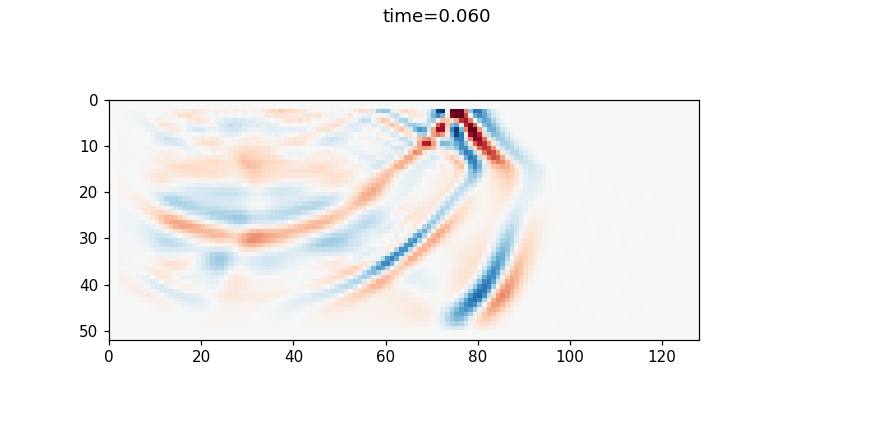

In [11]:
it=0;is1=0
startt=time.time()
#
%matplotlib notebook
import matplotlib
fig=plt.figure(figsize=(8,4))
gs=GridSpec(1,3)
ax1 = plt.subplot2grid((1,8), (0,0), colspan=7)
#ax2 = plt.subplot2grid((1,8), (0,7))
plt.ion()
fig.show()
fig.canvas.draw()
aspectratio=1.0
ratio_default=(ax1.get_xlim()[1]-ax1.get_xlim()[0])/(ax1.get_ylim()[1]-ax1.get_ylim()[0])
ax1.set_aspect(ratio_default*aspectratio)
plt.gca().invert_yaxis()
#ax2.set_aspect(4)
#
init(v1,v2,s11,s22,s12)
try:
    while(it < ntime):
        it = it+1;
        memvar(m11,mm11,m22,mm22,m12,mm12)
        stress_o4(s11,s22,s12)
        stress_o2(s11,s22,s12)
        ssource(s11,s22)
        vel_o4(v1,v2)
        vel_o2(v1,v2)
        is1 = is1+1
        if (is1 > nos2):        
            plo();
            is1=0  
            #print ("it="+str(it)+" — time="+str(round(it*dt,3))+" s")
except KeyboardInterrupt:
    pass